<a href="https://colab.research.google.com/github/sayarghoshroy/Intro_to_DL_tutorial/blob/master/CNN_image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic image classification




Please upload the necessary files (dataset) before sunning the code. The files to be uploaded include - 

*   train.csv
*   test.csv
*   train_images.zip
*   test_images.zip


In [11]:
!gdown --id 1sNDRnD2_Vu5peFcPoteSFzmS8oC7S6Iq
!gdown --id 1PvokgUfEwJYSsLgKoJa5pw8iCQzS7y69
!gdown --id 1Bcq1AcWgfkIqsoZ0tzrXLfivv4X0uwWy
!gdown --id 1gRq9rMFFOKdM0HSz94lGrYxujuJPGS4b

Downloading...
From: https://drive.google.com/uc?id=1sNDRnD2_Vu5peFcPoteSFzmS8oC7S6Iq
To: /content/train.csv
100% 253k/253k [00:00<00:00, 8.14MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PvokgUfEwJYSsLgKoJa5pw8iCQzS7y69
To: /content/test.csv
100% 7.27k/7.27k [00:00<00:00, 10.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Bcq1AcWgfkIqsoZ0tzrXLfivv4X0uwWy
To: /content/train_images.zip
754MB [00:06, 120MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gRq9rMFFOKdM0HSz94lGrYxujuJPGS4b
To: /content/test_images.zip
33.9MB [00:00, 129MB/s] 


In [12]:
!rm -rf data
!mkdir data

In [13]:
!mkdir data/test
!mkdir data/train
!unzip train_images -d data/train
!unzip test_images -d data/test

Streaming output truncated to the last 5000 lines.
  inflating: data/train/train_images/22d805cf15.jpg  
  inflating: data/train/train_images/145896eed0.jpg  
  inflating: data/train/train_images/c468193dfd.jpg  
  inflating: data/train/train_images/7c6dccda37.jpg  
  inflating: data/train/train_images/c03811cd27.jpg  
  inflating: data/train/train_images/f04e23613b.jpg  
  inflating: data/train/train_images/d1cbbc1134.jpg  
  inflating: data/train/train_images/d762ff4fd3.jpg  
  inflating: data/train/train_images/1df8826db5.jpg  
  inflating: data/train/train_images/4f05c60d04.jpg  
  inflating: data/train/train_images/1b33d95837.jpg  
  inflating: data/train/train_images/fa3e225fe7.jpg  
  inflating: data/train/train_images/7bcd015a19.jpg  
  inflating: data/train/train_images/a413778c2b.jpg  
  inflating: data/train/train_images/4945972217.jpg  
  inflating: data/train/train_images/5245cffff8.jpg  
  inflating: data/train/train_images/6012b508f4.jpg  
  inflating: data/train/train_i

In [14]:
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import models
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
%matplotlib inline

Constructing the dataset class

In [15]:
class PicsData(Dataset):
  def __init__(self,data,path='./',transform=None,Totrain = True):
    super().__init__()
    self.data = data
    self.path = path
    self.transform = transform 
    self.Totrain = Totrain

  def __len__(self):
    # print (self.data)
    # print (self.data.shape[0],len(self.data))
    # print (self.data.iloc[0])
    return len(self.data)
  
  def __getitem__(self,index):
    if self.Totrain:
      imgname, label = self.data.iloc[index]
    else:
      imgname = self.data.iloc[index]['ImageId']
      # print (imgname)
    path = os.path.join(self.path, imgname)
    img = cv2.imread(path,1)
    img = cv2.resize(img,(64,64))
    if self.transform is not None:
      img = self.transform(img)
    if self.Totrain:
      return img,label
    else :
      return img


In [16]:
transforms_train = transforms.Compose([
                                       transforms.ToPILImage(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
trnpath = 'data/train/train_images'


In [17]:
labels = pd.read_csv('./train.csv')
label_encoder = preprocessing.LabelEncoder()
encoded = label_encoder.fit_transform(labels['ClassName'])
traindf = labels
traindf['ClassName'] =  encoded

In [18]:
train_data = PicsData(traindf,trnpath,transforms_train)
train_data.__len__()

9323

In [19]:
batch = 200
valid_size = 0.2
num = train_data.__len__()

train_split, val_split = train_test_split(traindf, stratify=traindf['ClassName'], test_size=0.2)

train_data = PicsData(train_split,trnpath,transforms_train)
val_data = PicsData(val_split,trnpath,transforms_train)

train_loader = DataLoader(train_data, batch_size = batch)
val_loader = DataLoader(val_data, batch_size = batch)



In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


Defining a training function which takes as argument the model, loss function, optimizer and number of epochs. 

In [21]:
# keeping-track-of-losses 

def trainer (model, lossfn, optimizer, num_epochs=10):
  train_losses = []
  valid_losses = []

  for epoch in range(1, num_epochs + 1):
      # keep-track-of-training-and-validation-loss
      train_loss = 0.0
      valid_loss = 0.0
      
      # training-the-model
      model.train()
      for data, target in train_loader:
          # print (data.shape)
          # print (target)
          # move-tensors-to-GPU 
          data = data.squeeze(0).to(device)
          target = target.to(device)
          
          # clear-the-gradients-of-all-optimized-variables
          optimizer.zero_grad()
          # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
          output = model(data)
          # calculate-the-batch-loss
          loss = lossfn(output, target)
          # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
          loss.backward()
          # perform-a-ingle-optimization-step (parameter-update)
          optimizer.step()
          # update-training-loss
          train_loss += loss.item() * data.size(0)
          
      # validate-the-model
      model.eval()
      for data, target in val_loader:
          
          data = data.to(device)
          target = target.to(device)
          
          output = model(data)
          
          loss = lossfn(output, target)
          
          # update-average-validation-loss 
          valid_loss += loss.item() * data.size(0)
      
      # calculate-average-losses
      train_loss = train_loss/len(train_loader.sampler)
      valid_loss = valid_loss/len(val_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
          
      # print-training/validation-statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
  return model,train_losses, valid_losses

Just a helper function for plotting graphs

In [22]:
def plotter(trainloss,valloss,tit):
  plt.title(tit)

  plt.subplot(1, 2, 1)
  plt.plot(trainloss, 'ko-')
  plt.ylabel('Train loss')
  plt.xlabel('epochs')


  plt.subplot(1, 2, 2)
  plt.plot(valloss, 'r.-')
  plt.xlabel('epochs')
  plt.ylabel('validation loss')
  plt.tight_layout()


# Baseline

Baseline Cnn model with 2 convolution and 3 fully connected layers

In [23]:
class BaseNet(nn.Module):
  # Define layers here
    def __init__(self):
        super(BaseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(int(12544*4), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)

    def forward(self, x):
      # Forward pass
        x = (F.relu(self.conv1(x)))
        x = (F.relu(self.conv2(x)))
        x = x.view(-1, int(12544*4))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
model = BaseNet().to(device)
# print (model)
learning_rate = 0.001

lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [25]:
Basemodel, basetrnls, basevalls = trainer(model,lossfn,optimizer,15)

Epoch: 1 	Training Loss: 3.688934 	Validation Loss: 3.453336
Epoch: 2 	Training Loss: 3.298843 	Validation Loss: 3.283023
Epoch: 3 	Training Loss: 3.032970 	Validation Loss: 3.205418
Epoch: 4 	Training Loss: 2.765890 	Validation Loss: 3.156710
Epoch: 5 	Training Loss: 2.500854 	Validation Loss: 3.174504
Epoch: 6 	Training Loss: 2.195305 	Validation Loss: 3.306017
Epoch: 7 	Training Loss: 1.876711 	Validation Loss: 3.455636
Epoch: 8 	Training Loss: 1.512495 	Validation Loss: 4.034253
Epoch: 9 	Training Loss: 1.213261 	Validation Loss: 4.126999
Epoch: 10 	Training Loss: 0.895447 	Validation Loss: 4.543779
Epoch: 11 	Training Loss: 0.682213 	Validation Loss: 4.858324
Epoch: 12 	Training Loss: 0.513697 	Validation Loss: 5.144761
Epoch: 13 	Training Loss: 0.342312 	Validation Loss: 5.600975
Epoch: 14 	Training Loss: 0.220204 	Validation Loss: 5.659384
Epoch: 15 	Training Loss: 0.146430 	Validation Loss: 5.808844


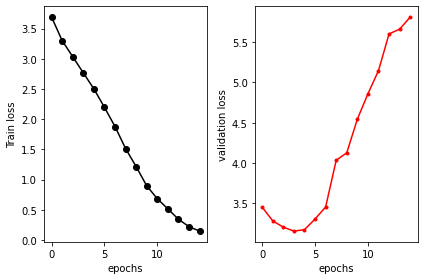

In [26]:
plotter(basetrnls,basevalls,'Baseline')

As seen from the graph, it can be observed that the baseline network start to overfit very quickly (after 3 epochs) since the train loss keeps on decreasing but the validation loss increases 

The baseline network contains 2 convolution layers followed by 3 fully connected layers. There are no dropouts added. An adam optimiser with cross entropy loss is used. Each layer is passed through a Relu activation 

# With Batch Norm

In [27]:
class NormNet(nn.Module):
  # Define layers here
    def __init__(self):
        super(NormNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(int(12544*4), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)

    def forward(self, x):
      # Forward pass
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = x.view(-1, int(12544*4))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [28]:
NormModel = NormNet().to(device)
Normoptim = torch.optim.Adam(NormModel.parameters(),lr = learning_rate)

NormModel, trnloss, valloss = trainer(NormModel, nn.CrossEntropyLoss(), Normoptim,15)

Epoch: 1 	Training Loss: 3.892214 	Validation Loss: 3.527710
Epoch: 2 	Training Loss: 3.245678 	Validation Loss: 3.345775
Epoch: 3 	Training Loss: 2.836432 	Validation Loss: 3.251365
Epoch: 4 	Training Loss: 2.436022 	Validation Loss: 3.347056
Epoch: 5 	Training Loss: 2.016995 	Validation Loss: 3.550248
Epoch: 6 	Training Loss: 1.615456 	Validation Loss: 4.111109
Epoch: 7 	Training Loss: 1.357572 	Validation Loss: 4.988458
Epoch: 8 	Training Loss: 1.299196 	Validation Loss: 4.778759
Epoch: 9 	Training Loss: 1.080453 	Validation Loss: 5.565812
Epoch: 10 	Training Loss: 0.981737 	Validation Loss: 5.680859
Epoch: 11 	Training Loss: 0.692989 	Validation Loss: 5.350833
Epoch: 12 	Training Loss: 0.657296 	Validation Loss: 6.241713
Epoch: 13 	Training Loss: 0.607448 	Validation Loss: 7.002873
Epoch: 14 	Training Loss: 0.541481 	Validation Loss: 5.854145
Epoch: 15 	Training Loss: 0.285304 	Validation Loss: 5.510297


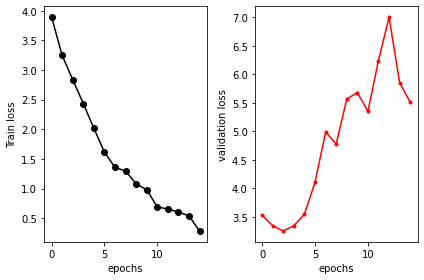

In [29]:
plotter(trnloss,valloss,'Normnet')

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch
it continuously takes the output from the previous layer and normalizes it before sending it to the next layer. This has the effect of stabilizing the neural network

Since it is more effective for deep networks, much effect can not be seen over our baseline since it has very few layers 

We can observe that the training is faster, i.e the decrease in training loss over iterations is more than that compared to the baseline model. 
However, The problem of over fitting still exists even with the batchnorm

# Adding new layers


In [30]:
class NewLayerNet(nn.Module):
  # Define layers here
    def __init__(self):
        super(NewLayerNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.conv3 = nn.Conv2d(12, 18, 5)
        self.fc1 = nn.Linear(18* 52 * 13, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 61)

    def forward(self, x):
      # Forward pass
        x = (F.relu(self.conv1(x)))
        x = (F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 18*52*13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [31]:
NewLayerModel = NewLayerNet().to(device)
NewLayeroptim = torch.optim.Adam(NewLayerModel.parameters(),lr = learning_rate)

NewLayerModel, trnloss, valloss = trainer(NewLayerModel, nn.CrossEntropyLoss(), NewLayeroptim,15)

Epoch: 1 	Training Loss: 3.856973 	Validation Loss: 3.747719
Epoch: 2 	Training Loss: 3.670464 	Validation Loss: 3.565340
Epoch: 3 	Training Loss: 3.447409 	Validation Loss: 3.368225
Epoch: 4 	Training Loss: 3.293628 	Validation Loss: 3.282184
Epoch: 5 	Training Loss: 3.169809 	Validation Loss: 3.186433
Epoch: 6 	Training Loss: 3.055530 	Validation Loss: 3.127847
Epoch: 7 	Training Loss: 2.962647 	Validation Loss: 3.098886
Epoch: 8 	Training Loss: 2.881786 	Validation Loss: 3.072844
Epoch: 9 	Training Loss: 2.807928 	Validation Loss: 3.052523
Epoch: 10 	Training Loss: 2.715879 	Validation Loss: 3.041004
Epoch: 11 	Training Loss: 2.652864 	Validation Loss: 3.010226
Epoch: 12 	Training Loss: 2.579243 	Validation Loss: 3.109576
Epoch: 13 	Training Loss: 2.497690 	Validation Loss: 3.161033
Epoch: 14 	Training Loss: 2.378696 	Validation Loss: 3.220211
Epoch: 15 	Training Loss: 2.292779 	Validation Loss: 3.194477


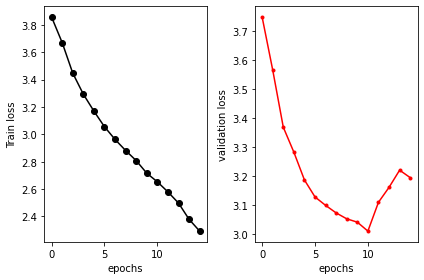

In [32]:
plotter(trnloss,valloss,'Extra Layers')

We add 1 extra convolution layer and 1 linear fully connected layer to our baseline model. Adding new layers increases the depth of the neural network and prevents over fitting. As we can see, accross epochs tha validation loss also decreases along with the training loss 
The lowes achieved validation loss also improves

## With Dropout

In [37]:
class DropoutNet(nn.Module):
  # Define layers here
    def __init__(self,dropProb = 0.2,input_shape = (3,64,64)):
        super(DropoutNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(int(12544*4) , 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)
        self.dropout2d = nn.Dropout2d(dropProb)
        self.dropout = nn.Dropout(dropProb)


    def forward(self, x):
      # Forward pass
        x = (F.relu(self.conv1(x)))
        x = self.dropout2d(x)
        x = (F.relu(self.conv2(x)))
        x = x.view(-1, int(12544*4))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [38]:
DropoutModel = DropoutNet().to(device)
Dropoutoptim = torch.optim.Adam(DropoutModel.parameters(),lr = learning_rate)

DropoutModel, trnloss, valloss = trainer(DropoutModel, nn.CrossEntropyLoss(), Dropoutoptim,15)

Epoch: 1 	Training Loss: 3.834138 	Validation Loss: 3.613172
Epoch: 2 	Training Loss: 3.562959 	Validation Loss: 3.369893
Epoch: 3 	Training Loss: 3.349579 	Validation Loss: 3.257109
Epoch: 4 	Training Loss: 3.145102 	Validation Loss: 3.190226
Epoch: 5 	Training Loss: 2.962977 	Validation Loss: 3.150182
Epoch: 6 	Training Loss: 2.751296 	Validation Loss: 3.145955
Epoch: 7 	Training Loss: 2.517700 	Validation Loss: 3.273351
Epoch: 8 	Training Loss: 2.298853 	Validation Loss: 3.445790
Epoch: 9 	Training Loss: 1.980725 	Validation Loss: 3.600077
Epoch: 10 	Training Loss: 1.733071 	Validation Loss: 3.851915
Epoch: 11 	Training Loss: 1.541097 	Validation Loss: 4.070960
Epoch: 12 	Training Loss: 1.325819 	Validation Loss: 4.255785
Epoch: 13 	Training Loss: 1.092610 	Validation Loss: 4.713675
Epoch: 14 	Training Loss: 0.892892 	Validation Loss: 5.168061
Epoch: 15 	Training Loss: 0.789006 	Validation Loss: 5.290830


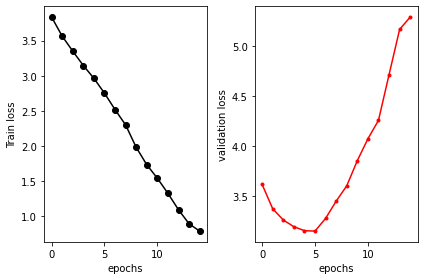

In [39]:
plotter(trnloss,valloss,'Dropout Layers')

Dropout is a very common regularization technique for neural networks which is used to prevent overfitting of the neural network by randomly dropping or deactivating some of the neorons of the neural layer. 

We keep the probability of dropping a neuron by 0.2 

As we can see from the graph the over fitting has been drastically prevented from the dropout and the validatoion loss decreases along with the train loss and the lowest validation loss achieved is 3.078415


# different activation functions 

In [40]:
class SoftNet(nn.Module):
  # Define layers here
    def __init__(self,dropProb = 0.2,input_shape = (3,64,64)):
        super(SoftNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(int(12544*4) , 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)
        # self.dropout2d = nn.Dropout2d(dropProb)
        # self.dropout = nn.Dropout(dropProb)

    def forward(self, x):
      # Forward pass
        x = (F.softmax(self.conv1(x)))
        # x = self.dropout2d(x)
        x = (F.softmax(self.conv2(x)))
        x = x.view(-1, int(12544*4))
        x = F.softmax(self.fc1(x))
        x = F.softmax(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)
        return x


In [41]:
SoftModel = SoftNet().to(device)
Softoptim = torch.optim.Adam(SoftModel.parameters(),lr = learning_rate)

SoftModel, trnloss, valloss = trainer(SoftModel, nn.CrossEntropyLoss(), Softoptim,15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 4.098538 	Validation Loss: 4.077717
Epoch: 2 	Training Loss: 4.060040 	Validation Loss: 4.041313
Epoch: 3 	Training Loss: 4.025483 	Validation Loss: 4.008600
Epoch: 4 	Training Loss: 3.994446 	Validation Loss: 3.979221
Epoch: 5 	Training Loss: 3.966582 	Validation Loss: 3.952847
Epoch: 6 	Training Loss: 3.941578 	Validation Loss: 3.929180
Epoch: 7 	Training Loss: 3.919153 	Validation Loss: 3.907965
Epoch: 8 	Training Loss: 3.899072 	Validation Loss: 3.888988
Epoch: 9 	Training Loss: 3.881145 	Validation Loss: 3.872083
Epoch: 10 	Training Loss: 3.865222 	Validation Loss: 3.857118
Epoch: 11 	Training Loss: 3.851183 	Validation Loss: 3.843985
Epoch: 12 	Training Loss: 3.838924 	Validation Loss: 3.832581
Epoch: 13 	Training Loss: 3.828341 	Validation Loss: 3.822799
Epoch: 14 	Training Loss: 3.819317 	Validation Loss: 3.814515
Epoch: 15 	Training Loss: 3.811722 	Validation Loss: 3.807588


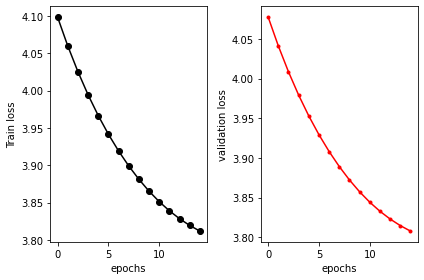

In [42]:
plotter(trnloss,valloss,'SoftMax Activation')

We use softmax instead of the Relu activation, 

Softmax functions map the output of the neural network layer between 0 and 1 and makes sure that the sum of all the mapped outputs is 1
The softmax function is often used in the final layer of a neural network-based classifier since the outputs can then be directly interpretted as probabilities 

RELU is the most popular activation function for deep neural networks. It just converts all negative outputs to 0 and reserves the positive ones 

from the graph it can be observed that softmax perfoms better in case of preventing over fitting but at the same time is much slower than Relu 


In [43]:
class LeakyNet(nn.Module):
  # Define layers here
    def __init__(self,dropProb = 0.2,input_shape = (3,64,64)):
        super(LeakyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(int(1605632/128) , 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)
        self.dropout2d = nn.Dropout2d(dropProb)
        self.dropout = nn.Dropout(dropProb)

    def forward(self, x):
      # Forward pass
        x = (F.leaky_relu(self.conv1(x)))
        x = self.dropout2d(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, int(1605632/128))
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# Different Pooling strategies 

In [44]:
class PoolNet(nn.Module):
  # Define layers here
    def __init__(self):
        super(PoolNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(int(540800/200), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 61)

    def forward(self, x):
      # Forward pass
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.view(-1, int(540800/200))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
PoolModel = PoolNet().to(device)
Pooloptim = torch.optim.Adam(PoolModel.parameters(),lr = learning_rate)

PoolModel, trnloss, valloss = trainer(PoolModel, nn.CrossEntropyLoss(), Pooloptim,15)

Epoch: 1 	Training Loss: 3.831475 	Validation Loss: 3.658305
Epoch: 2 	Training Loss: 3.580680 	Validation Loss: 3.492904
Epoch: 3 	Training Loss: 3.366939 	Validation Loss: 3.314220
Epoch: 4 	Training Loss: 3.201392 	Validation Loss: 3.241351
Epoch: 5 	Training Loss: 3.113320 	Validation Loss: 3.170454
Epoch: 6 	Training Loss: 3.049623 	Validation Loss: 3.117285
Epoch: 7 	Training Loss: 2.993960 	Validation Loss: 3.083173
Epoch: 8 	Training Loss: 2.941076 	Validation Loss: 3.066567
Epoch: 9 	Training Loss: 2.888078 	Validation Loss: 3.032667
Epoch: 10 	Training Loss: 2.839505 	Validation Loss: 3.015612
Epoch: 11 	Training Loss: 2.788444 	Validation Loss: 2.999790
Epoch: 12 	Training Loss: 2.737716 	Validation Loss: 2.992637
Epoch: 13 	Training Loss: 2.685969 	Validation Loss: 2.985771
Epoch: 14 	Training Loss: 2.636560 	Validation Loss: 2.990006
Epoch: 15 	Training Loss: 2.592362 	Validation Loss: 2.989740


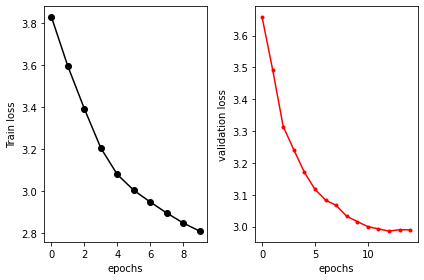

In [46]:
trnloss = [3.827345,3.592491,3.391248,3.204462,3.078889,3.003845,2.948112,2.895925,2.848373,2.809717]
vallos = [3.680030,3.455600,3.280426,3.141777,3.081579,3.042602,3.018918,3.010314,3.011385,2.984053]
plotter(trnloss,valloss,'Pooling Layers')

Pool reduces the number of parameters in the model by down-sampling. it iterates over the windows of a given size to only take the max of the element on that window. Pooling in theory helps improve the detection of the features since it makes them invariant to scale This in a way, also prevents over fitting. As we can see from the graph the results are much better compared to the baseline since the validation accuracy improves at a decent rate and reaches an all time low of 2.984053

other pooling techniques also include average pooling

we add a maxpooling operation of 2x2 size to both the convolutional layers 

# Different optimizers

In [47]:
SGDModel = BaseNet().to(device)
SGDoptim = torch.optim.SGD(SGDModel.parameters(),lr=0.001, momentum=0.9)
SGDModel, trnloss, valloss = trainer(SGDModel, nn.CrossEntropyLoss(), SGDoptim,15)

Epoch: 1 	Training Loss: 4.090791 	Validation Loss: 4.066381
Epoch: 2 	Training Loss: 4.024251 	Validation Loss: 3.957992
Epoch: 3 	Training Loss: 3.898789 	Validation Loss: 3.851286
Epoch: 4 	Training Loss: 3.832273 	Validation Loss: 3.805022
Epoch: 5 	Training Loss: 3.797542 	Validation Loss: 3.776230
Epoch: 6 	Training Loss: 3.770962 	Validation Loss: 3.750894
Epoch: 7 	Training Loss: 3.745566 	Validation Loss: 3.725029
Epoch: 8 	Training Loss: 3.718968 	Validation Loss: 3.696972
Epoch: 9 	Training Loss: 3.688698 	Validation Loss: 3.665767
Epoch: 10 	Training Loss: 3.653227 	Validation Loss: 3.629172
Epoch: 11 	Training Loss: 3.611154 	Validation Loss: 3.589202
Epoch: 12 	Training Loss: 3.562552 	Validation Loss: 3.546723
Epoch: 13 	Training Loss: 3.508287 	Validation Loss: 3.503419
Epoch: 14 	Training Loss: 3.452673 	Validation Loss: 3.461102
Epoch: 15 	Training Loss: 3.398486 	Validation Loss: 3.422257


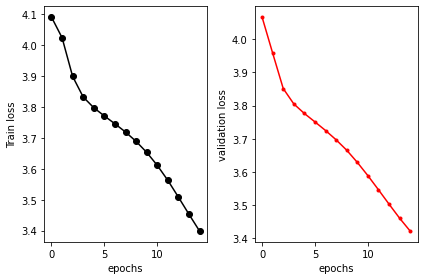

In [48]:
plotter(trnloss,valloss,'SGD optimisers')

We try different optimisers with our base model. Optimisers are used to optimise the weights of the neural network with the objective of reducing the training loss 

We check with the SGD and the adam optimers. 
SGD or Stochastic Gradient Discent  updates all the parameters for each training example individually, instead of computing the gradient of the cost function with respect to the parameters for the whole training set.

We can see that Adam performs significantly better than the sgd in terms of the learning rate and SGD improvements over losses are very slow. The final loss is also lower for both training and testing with ADAM

Other optimisers like adagrad can also be used


# Basic Augmentation like Rotation, Translation, Color Change

In [49]:
train_transforms = transforms.Compose([
                                       transforms.ToPILImage(),
                                       transforms.ColorJitter(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
trnpath = 'data/train/train_images'
val_transform = transforms.Compose([
                                       transforms.ToPILImage(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [50]:
batch = 200
valid_size = 0.2
num = train_data.__len__()

train_split, val_split = train_test_split(traindf, stratify=traindf['ClassName'], test_size=0.2)

train_data = PicsData(train_split,trnpath,train_transforms)
val_data = PicsData(val_split,trnpath,val_transform)

train_loader = DataLoader(train_data, batch_size = batch)
val_loader = DataLoader(val_data, batch_size = batch)

In [51]:
Augmodel = BaseNet().to(device)
# print (model)
learning_rate = 0.001

lossfn = nn.CrossEntropyLoss()
Augoptimizer = torch.optim.Adam(Augmodel.parameters(),lr = learning_rate)

In [52]:
Augmodel, basetrnls, basevalls = trainer(Augmodel,lossfn,Augoptimizer,15)

Epoch: 1 	Training Loss: 3.743603 	Validation Loss: 3.546611
Epoch: 2 	Training Loss: 3.371305 	Validation Loss: 3.281530
Epoch: 3 	Training Loss: 3.094651 	Validation Loss: 3.144569
Epoch: 4 	Training Loss: 2.911947 	Validation Loss: 3.113126
Epoch: 5 	Training Loss: 2.756686 	Validation Loss: 3.076216
Epoch: 6 	Training Loss: 2.616140 	Validation Loss: 3.108576
Epoch: 7 	Training Loss: 2.476610 	Validation Loss: 3.208717
Epoch: 8 	Training Loss: 2.349492 	Validation Loss: 3.229006
Epoch: 9 	Training Loss: 2.213765 	Validation Loss: 3.340884
Epoch: 10 	Training Loss: 2.073542 	Validation Loss: 3.433274
Epoch: 11 	Training Loss: 1.931768 	Validation Loss: 3.519103
Epoch: 12 	Training Loss: 1.735720 	Validation Loss: 3.597814
Epoch: 13 	Training Loss: 1.565285 	Validation Loss: 3.831492
Epoch: 14 	Training Loss: 1.399427 	Validation Loss: 4.012609
Epoch: 15 	Training Loss: 1.267665 	Validation Loss: 4.200605


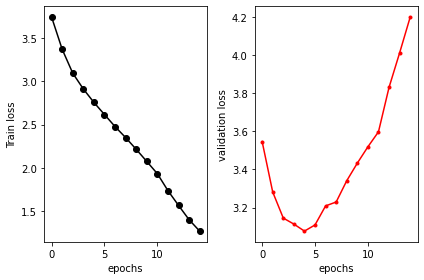

In [53]:
plotter(basetrnls,basevalls,'Augmented data')

We add data augmentation by adding rotation and colour jitter  using the transform method of torchvision. This creates different versions of the data for each epoch and prevents over fitting. 

# Scheduler


a Scheduler is used to decay the learning rate after certain epochs of training so that the model does not oscilate around the  minima. 
This gives significant imporivements when paired with optimisers like SGD which are prone to oscilaaitons around minima. 

In [54]:
# keeping-track-of-losses 

def Schtrainer (model, lossfn, optimizer,scheduler, num_epochs=10):
  train_losses = []
  valid_losses = []

  for epoch in range(1, num_epochs + 1):
      # keep-track-of-training-and-validation-loss
      train_loss = 0.0
      valid_loss = 0.0
      
      # training-the-model
      model.train()
      scheduler.step()
      for data, target in train_loader:
          # print (data.shape)
          # print (target)
          # move-tensors-to-GPU 
          data = data.squeeze(0).to(device)
          target = target.to(device)
          
          # clear-the-gradients-of-all-optimized-variables
          optimizer.zero_grad()
          # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
          output = model(data)
          # calculate-the-batch-loss
          loss = lossfn(output, target)
          # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
          loss.backward()
          # perform-a-ingle-optimization-step (parameter-update)
          optimizer.step()
          # update-training-loss
          train_loss += loss.item() * data.size(0)
          
      # validate-the-model
      model.eval()
      for data, target in val_loader:
          
          data = data.to(device)
          target = target.to(device)
          
          output = model(data)
          
          loss = lossfn(output, target)
          
          # update-average-validation-loss 
          valid_loss += loss.item() * data.size(0)
      
      # calculate-average-losses
      train_loss = train_loss/len(train_loader.sampler)
      valid_loss = valid_loss/len(val_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
          
      # print-training/validation-statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
  return model,train_losses, valid_losses

In [55]:
from torch.optim import lr_scheduler

# print (model)
Schemodel = BaseNet().to(device)
learning_rate = 0.01
lossfn = nn.CrossEntropyLoss()
Scheoptimizer = torch.optim.Adam(Schemodel.parameters(),lr = learning_rate)
sched = lr_scheduler.StepLR(Scheoptimizer, step_size=2, gamma=0.1)

Schemodel, basetrnls, basevalls = Schtrainer(Schemodel,lossfn,Scheoptimizer,sched,15)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1 	Training Loss: 4.186096 	Validation Loss: 3.793550
Epoch: 2 	Training Loss: 3.789345 	Validation Loss: 3.782220
Epoch: 3 	Training Loss: 3.782846 	Validation Loss: 3.780264
Epoch: 4 	Training Loss: 3.780656 	Validation Loss: 3.780180
Epoch: 5 	Training Loss: 3.780582 	Validation Loss: 3.780111
Epoch: 6 	Training Loss: 3.780419 	Validation Loss: 3.780105
Epoch: 7 	Training Loss: 3.780412 	Validation Loss: 3.780098
Epoch: 8 	Training Loss: 3.780396 	Validation Loss: 3.780098
Epoch: 9 	Training Loss: 3.780395 	Validation Loss: 3.780097
Epoch: 10 	Training Loss: 3.780394 	Validation Loss: 3.780097
Epoch: 11 	Training Loss: 3.780394 	Validation Loss: 3.780097
Epoch: 12 	Training Loss: 3.780394 	Validation Loss: 3.780097
Epoch: 13 	Training Loss: 3.780394 	Validation Loss: 3.780097
Epoch: 14 	Training Loss: 3.780394 	Validation Loss: 3.780097
Epoch: 15 	Training Loss: 3.780394 	Validation Loss: 3.780097


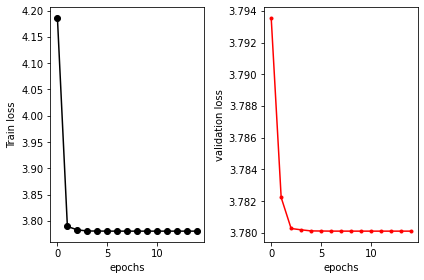

In [56]:
plotter(basetrnls,basevalls,'Augmented data')

as we can see since the LR reduces, the changes in losses also reduce


## Test code


In [57]:
Le a rn i n g  Ch a ra cte r-level  Representations  for Part-of-Spe e ch  TaggingDos Santos and Zadrozny(2014)t.csv')
test_data = PicsData(test,test_path,transforms_train,False)

test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)

In [58]:
model.eval()

preds = []
with torch.no_grad():
    for images in test_loader:
        # print (l)
        data = images.squeeze(0).to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        pr = predicted.detach().cpu().numpy()
        for i in pr:
          preds.append(i)

In [59]:
df = pd.DataFrame(label_encoder.inverse_transform(preds),columns=['ClassName'])
df.to_csv('submission.csv',index=False)